In [1]:
%matplotlib inline
from __future__ import print_function

import rospy
import rosbag
import itertools
from  tqdm import tqdm
from geometry_msgs.msg import PoseWithCovarianceStamped
import tf
import numpy as np
import time

import matplotlib.pyplot as plt
import os

%load_ext autoreload
%autoreload 2

In [2]:
def create_gt(map_name):
    print(map_name, root_folder)
    gt_bag_filename = '{0:s}/{1:s}/rosbag/{1:s}_pointcloud_odom_gt.bag'.format(root_folder,map_name)
    if not os.path.isfile(gt_bag_filename):
        gt_bag_filename = '{0:s}/{1:s}/rosbag/{1:s}_pointcloud_gt.bag'.format(root_folder,map_name)
    if not os.path.isfile(gt_bag_filename):
        print('[Error] _gt.bag not found')
        return None

    #gt_bag_filename = '{0:s}/{1:s}/{1:s}_pointcloud_odom_gt.bag'.format(root_folder,map_name)
    #sensors_bag_filename = '{0:s}/{1:s}/{1:s}_sensors.bag'.format(root_folder,map_name)

    #odom_tf_bag_filename = '/tmp/odom_tf.bag'
    #odom_nav_bag_filename = '/tmp/odom_msg.bag'
    print('Reading {:60s}'.format(gt_bag_filename),end='')
    try: 
        gt_bag = rosbag.Bag(gt_bag_filename)
    except:
        gt_bag = rosbag.Bag(gt_bag_filename2)
    print('\t Done')
    time.sleep(0.2)
    
    t_offset = None

    Pose = list()
    for topic, msg, t in tqdm(gt_bag.read_messages(topics=['/carto_pose',])):
    #for topic, msg, t in bag.read_messages(topics=['/amcl_pose',]):
        #yaw angle
        rpy = tf.transformations.euler_from_quaternion((msg.pose.pose.orientation.x,
                                                        msg.pose.pose.orientation.y,
                                                        msg.pose.pose.orientation.z,
                                                        msg.pose.pose.orientation.w,
                                                        'xyzs'))
        if t_offset is None: t_offset = msg.header.stamp.secs - 300 # -5 minutes
        ti = msg.header.stamp.secs-t_offset + 1e-9*msg.header.stamp.nsecs
        Pose.append([ti,
                    msg.pose.pose.position.x,
                    msg.pose.pose.position.y,
                    np.cos(rpy[2]),
                    np.sin(rpy[2])])

    Pose = np.asarray(Pose)

    # Smooth traj
    eps_time = 1e-2#1e-2 #0.01
    del_sum = 0

    while(True):
        Diff = list()
        del_ind = list()
        min_time_jump = 1000
        for i in range(1,len(Pose)):
            dif = Pose[i,0]-Pose[i-1,0]
            Diff.append(dif)
            if dif < min_time_jump: min_time_jump = dif
            if dif <= eps_time: 
                del_ind.append(i)
                del_sum+=1;

    #    time_pose = np.delete(time_pose,del_ind)
        Pose = np.delete(Pose,del_ind,axis=0)
        print(min_time_jump)
        if (len(del_ind)==0): break
    
    return Pose, t_offset

# Example usage

In [3]:
# check files 
root_folder = '/mnt/matrix/rosbag/processed_data/nict'
map_name = 'udai-01'

Pose, t_offset = create_gt(map_name)

udai-01 /mnt/matrix/rosbag/processed_data/nict
Reading /mnt/matrix/rosbag/processed_data/nict/udai-01/rosbag/udai-01_pointcloud_odom_gt.bag	 Done


7666it [00:00, 19714.39it/s]


0.002025550000325893
0.9940555800003494


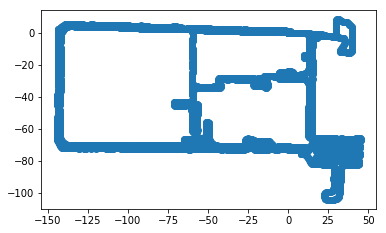

In [4]:
# Plot ground truth pose
f, ax = plt.subplots()
ax.scatter(Pose[:,1],Pose[:,2])
ax.set_aspect('equal')